In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

from sympy import symbols, cos, sin, acos, atan2, pi, simplify, diff, lambdify, det, solve
from sympy.matrices import Matrix
from sympy.plotting import plot
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
#constants
L, m1, m2, I1, I2,  = 0.2, 2, 2, 1, 2#symbols('L,m1, m2 , I1, I2', real=True)

#variables
phi, dphi, ddphi, s, ds, dds = symbols('phi, dphi, ddphi, s, ds, dds', real=True)

### Task1
**Find direct dynamic problem using Lagrange-Euler method. Suppose thatrobot located in a vertical plane, it means that we have gravity force with $g =9.81 \frac{m}{c^2}$.**

In [3]:
g = 9.81

### Step1: Let's Find Direct Kinematics

In [4]:
T1 = Rz(phi)
T1c = T1
R1 = T1[:3, :3]
R1c = R1
O1 = T1[:3, -1]
O1c = O1
O1

Matrix([
[0.0],
[0.0],
[0.0]])

In [5]:
T2 = Tx(s)*Tx(2*L)
T2c = Tx(s)*Tx(L)
T12 = T1 * T2
T12c = T1*T2c
R2 = T12[:3, :3]
R2c = T12c[:3, :3]
O2 = T12[:3, -1]
O2c = T12c[:3, -1]

O2

Matrix([
[(1.0*s + 0.4)*cos(phi)],
[(1.0*s + 0.4)*sin(phi)],
[                     0]])

In [6]:
O2c

Matrix([
[(1.0*s + 0.2)*cos(phi)],
[(1.0*s + 0.2)*sin(phi)],
[                     0]])

In [7]:
H = T1 * T2 
R = H[:3, :3]
O = H[:3, -1]
O

Matrix([
[(1.0*s + 0.4)*cos(phi)],
[(1.0*s + 0.4)*sin(phi)],
[                     0]])

In [8]:
H

Matrix([
[1.0*cos(phi), -1.0*sin(phi),   0, (1.0*s + 0.4)*cos(phi)],
[1.0*sin(phi),  1.0*cos(phi),   0, (1.0*s + 0.4)*sin(phi)],
[           0,             0, 1.0,                      0],
[           0,             0,   0,                    1.0]])

In [9]:
O0 = Matrix([0,0,0])
z1 = Matrix([0,0,1])
z1

Matrix([
[0],
[0],
[1]])

In [10]:
z2 = T1
z2 = z2[:3,0]#first column because translation is along X axis
z2 

Matrix([
[cos(phi)],
[sin(phi)],
[     0.0]])

### Step2: Calculate the Jacobians
We will use Skew Theory for this task

In [11]:
zer = Matrix([0,0,0])

**Linear Velocity Jacobians**

In [12]:
Jv1 = Matrix([[z1.cross(O1c - O0), zer]])
Jv1

Matrix([
[0, 0],
[0, 0],
[0, 0]])

In [13]:
Jv2 = Matrix([[z1.cross(O2c - O0), z2]])
Jv2

Matrix([
[-(1.0*s + 0.2)*sin(phi), cos(phi)],
[ (1.0*s + 0.2)*cos(phi), sin(phi)],
[                      0,      0.0]])

**Angular Velocity Jacobians**

In [14]:
Jw1 = Matrix([[z1, zer]])
Jw1

Matrix([
[0, 0],
[0, 0],
[1, 0]])

In [15]:
Jw2 = Matrix([[z1, zer]])
Jw2

Matrix([
[0, 0],
[0, 0],
[1, 0]])

### STEP3: Find the Inertia Matrix D

In [16]:
D1 = m1* Jv1.T @ Jv1 + Jw1.T @ R1 * I1 @ R1.T @ Jw1
D1

Matrix([
[1.0, 0],
[  0, 0]])

In [17]:
D2 = m2* Jv2.T @ Jv2 + Jw2.T @ R2 * I2 @ R2.T @ Jw2
simplify(D2)

Matrix([
[2.0*s**2 + 0.8*s + 2.08, 0],
[                      0, 2]])

In [18]:
D = D1 + D2
D = simplify(D)
D

Matrix([
[2.0*s**2 + 0.8*s + 3.08, 0],
[                      0, 2]])

In [19]:
np.array(D.subs([(phi, np.pi/2), (s, 1)])).astype(np.float)

array([[5.88, 0.  ],
       [0.  , 2.  ]])

### STEP4: Let's Find the Gradient of Potential Energy matrix ($G$)

In [20]:
P1 = m1*g*0
P2 = m2*g*(s+L)*sin(phi)

In [21]:
P = P1 + P2
P

(19.62*s + 3.924)*sin(phi)

In [22]:
G1 = diff(P, phi)
G1

(19.62*s + 3.924)*cos(phi)

In [23]:
G2 = diff(P, s)
G2

19.62*sin(phi)

In [24]:
G = Matrix([[G1, G2]])
G

Matrix([[(19.62*s + 3.924)*cos(phi), 19.62*sin(phi)]])

### STEP5: Find Coriolos matrix ($C$)

In [25]:
q = Matrix([phi, s])

dq = Matrix([dphi, ds])

ddq = Matrix([ddphi, dds])

In [26]:
def Coriolis(D, q, dq, n):
    C = Matrix([])
    for k in range(n):
        C_new_row = []
        for j in range(n):
            
            c_tmp = 0
            for i in range(n):
                c_ijk = 0.5*(diff(D[k,j],q[i]) + diff(D[k,i],q[j])-diff(D[i,j],q[k]))
                c_tmp += c_ijk*dq[i]
            C_new_row.append(c_tmp)
        C = C.row_insert(C.shape[0], Matrix([C_new_row]))
    return C

In [27]:
C = Coriolis(D,q,dq,2)
C

Matrix([
[   ds*(2.0*s + 0.4), dphi*(2.0*s + 0.4)],
[dphi*(-2.0*s - 0.4),                  0]])

### 2- Get the dynamic equation in matrix form:

$$M(q) * q^{..} + C(q, q^. ) * q^. + G(q) = \tau(t)$$

Where q is a vector of yours generalize coordinates.

In [28]:
tor = D @ ddq + C @ dq + G.T
tor

Matrix([
[ddphi*(2.0*s**2 + 0.8*s + 3.08) + 2*dphi*ds*(2.0*s + 0.4) + (19.62*s + 3.924)*cos(phi)],
[                                       2*dds + dphi**2*(-2.0*s - 0.4) + 19.62*sin(phi)]])

In [29]:
D_arr = lambda phi_val, s_val: np.array(D.subs([(phi, phi_val), (s, s_val)])).astype(np.float)

In [30]:
G_arr = lambda phi_val, s_val: np.array(G.subs([(phi, phi_val), (s, s_val)])).astype(np.float)

In [31]:
C_arr = lambda phi_val, s_val, dphi_val, ds_val: np.array((C*dq).subs([(phi, phi_val), (s, s_val),\
                                                                 (dphi, dphi_val), (ds, ds_val)])).astype(np.float)

### 3- Apply any force and torque functions 𝑓(𝑡) and 𝜏(𝑡) for the dynamic model.
### As result you will get new 𝑞(𝑡), 𝑞̇ (𝑡), 𝑞̈ (𝑡) function.

**Loop:**

$[\ddot{\phi}, \ddot{s}] = D(phi,s)^{-1}*(U-C(\phi, s,\dot{\phi},\dot{s})-G(\phi,s)^{T})$

$\dot{\phi} = \dot{\phi} + \ddot{\phi}*dt$

$\dot{s} = \dot{s} + \ddot{s}*dt$

$\phi = \phi + \dot{\phi}*dt$

$s = s + \dot{s}*dt$

**End_Loop;**

In [32]:
def simulator(q1_0, q2_0, dq1_0, dq2_0, dt, n=300):
    q1p, q2p, dq1p, dq2p = [], [], [], []
    for i in range(n):
        q1p.append(q1_0)
        q2p.append(q2_0)
        
        dq1p.append(dq1_0)
        dq2p.append(dq2_0)
            
        ddq = np.linalg.inv(D_arr(q1_0, q2_0))*(U-C_arr(q1_0, q2_0,dq1_0,dq2_0)-G_arr(q1_0,q2_0).T)

        dq1_0=dq1p[i] + ddq[0]*dt
        dq2_0=dq2p[i] + ddq[1]*dt
        q1_0 = q1p[i] + dq1_0*dt
        q2_0 = q2p[i] + dq2_0*dt
        

    t = list(np.arange(0, 0.1*(n), 0.1))
    fig1, axes1 = plt.subplots(nrows=2,ncols=2, figsize=(15, 15))
    fig1.subplots_adjust(hspace=.7,wspace=0.8)
    axes1[0,0].set_title('$\phi$ Angle')
    axes1[0,0].plot(t,q1p)
    axes1[0,1].set_title('$\dot{\phi}$ Angular Velocity')
    axes1[0,1].plot(t,dq1p)
    axes1[1,0].set_title('$s$ length')
    axes1[1,0].plot(t,q2p)
    axes1[1,1].set_title('$\dot{s}$ linear velocity')
    axes1[1,1].plot(t,dq2p)
  

**Let's try to test different positions and forces**

**1- We will test the case where the arm stands vertically with $\phi=\frac{\pi}{2}$**

In [33]:
U = Matrix([0, 0])

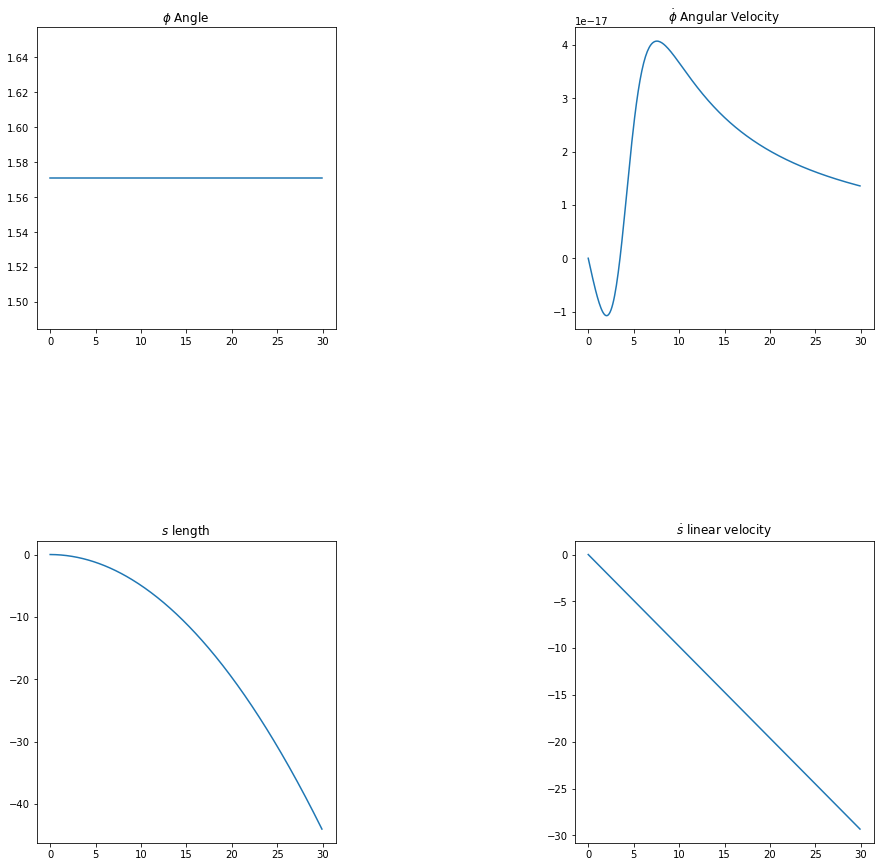

In [34]:
simulator(q1_0 = np.pi/2, q2_0 = 0, dq1_0 = 0, dq2_0 = 0, dt=0.01, n=300)

In [35]:
U = Matrix([-10, 1])

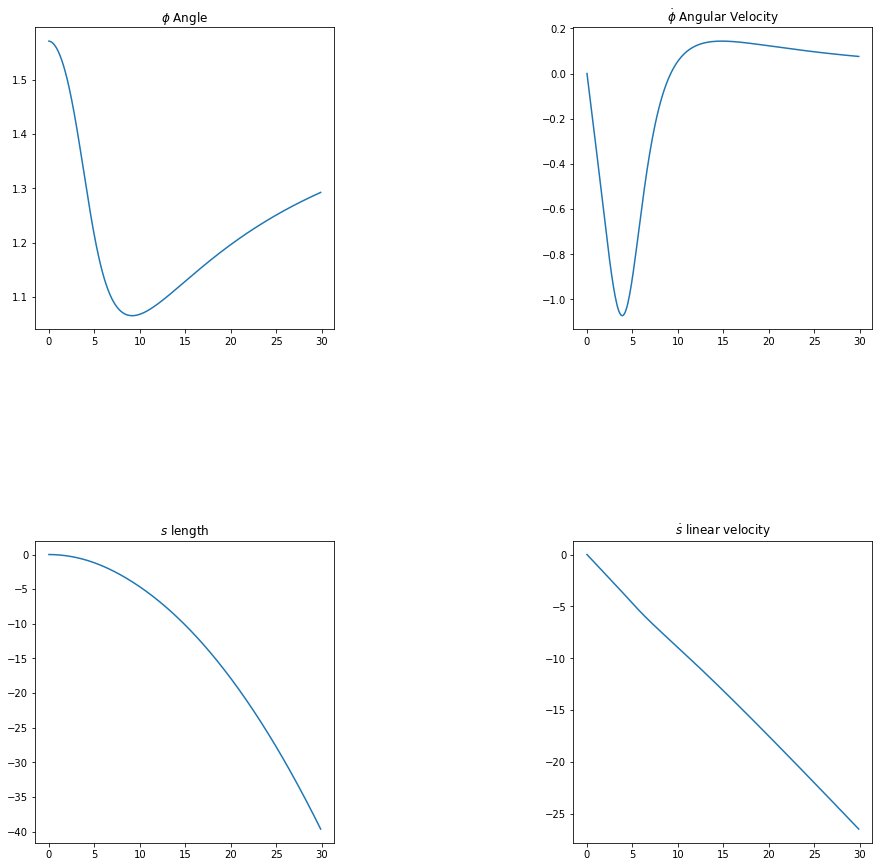

In [36]:
simulator(q1_0 = np.pi/2, q2_0 = 0, dq1_0 = 0, dq2_0 = 0, dt=0.01, n=300)

**2- Now we will test the case of having the $\phi=-\frac{\pi}{3}$ and $s=0$**

In [37]:
U = Matrix([0, 0])

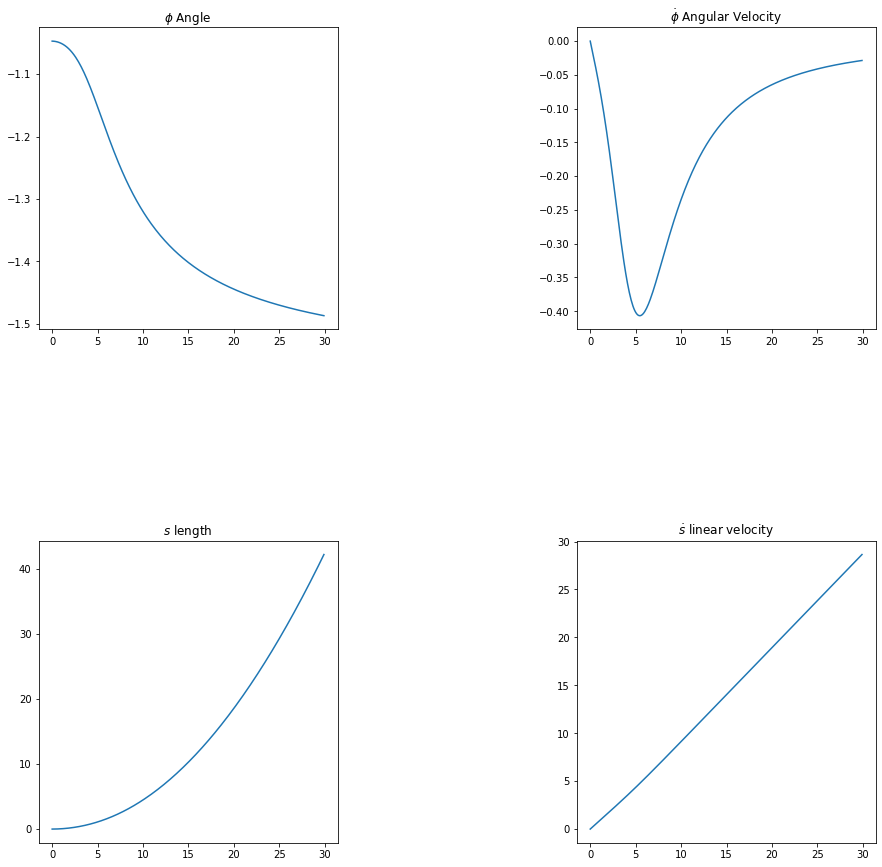

In [38]:
simulator(q1_0 = -np.pi/3, q2_0 = 0, dq1_0 = 0, dq2_0 = 0, dt=0.01, n=300)

In [39]:
U = Matrix([-10, 1])

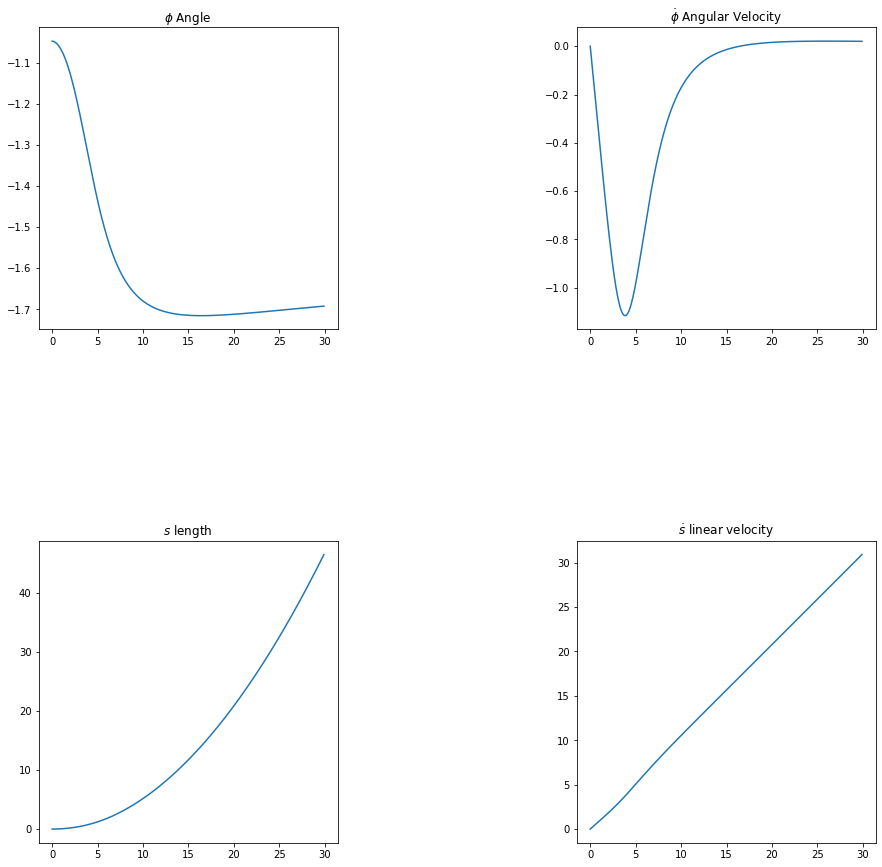

In [40]:
simulator(q1_0 = -np.pi/3, q2_0 = 0, dq1_0 = 0, dq2_0 = 0, dt=0.01, n=300)

**2- Now we will test the case of having the $\phi=0$ and $s=0$**

In [41]:
U = Matrix([25, 0])

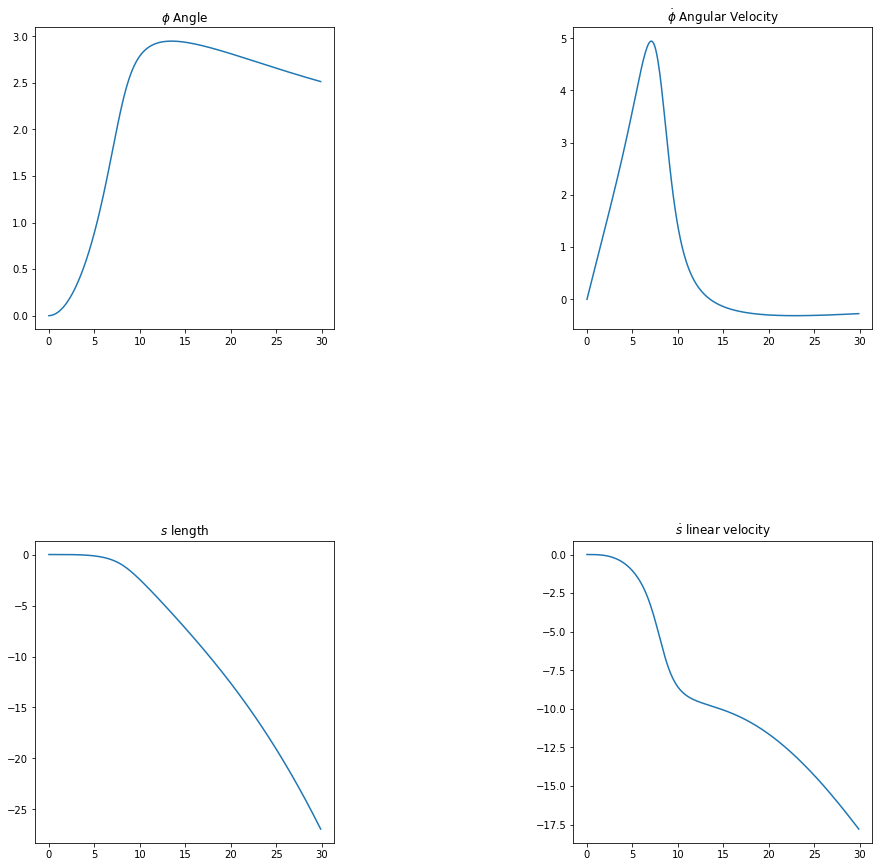

In [42]:
simulator(q1_0 = 0, q2_0 = 0, dq1_0 = 0, dq2_0 = 0, dt=0.01, n=300)